In [1]:
import numpy as np
import matplotlib.pyplot as plt
import butcher1 as butcher
import bro

from numpy import savetxt
from astropy.io import ascii
from astropy.time import Time
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.stats import median_absolute_deviation

from collections import deque
from bisect import insort, bisect_left
from itertools import islice

In [2]:
def binner(bins, time, flux, eflux):
    means, errors, midpoints = [], [], []
    for i in range(len(bins)-1):
        binned_mask = (time < bins[i+1])*(time > bins[i])
        if np.all(binned_mask == False):
            pass
        else:
            midpoints.append((bins[i] + bins[i+1])/2)
            means.append(np.average(flux[binned_mask], weights = 1/eflux[binned_mask]**2))
            errors.append(np.std(flux[binned_mask])/np.sqrt(len(flux[binned_mask])))
    return means, errors, midpoints

In [3]:
henk = np.array([True, True, False])
print(np.any(henk == True))

True


In [4]:
# find a0,a1,a2,a3,a4 that is the best fit to the plot above

def ringaling(phi,*c):
    # c is a numpy array containing an odd number of coeffieicnts
    # so that c[0] + c[1]*np.sin(phi) + c[2]*np.cos(phi) + c[3]*np.sin(2*phi) + c[4]*np.cos(2*phi) + .....
    #if (c.size%2 == 0):
    #    print('whoa! we need an odd number of coefficients in c')
    #    return 1
    c = np.array(c)
    npairs = (c.size-1)/2
    result = 0
    for i in np.arange(npairs):
        a_sin = c[((i*2)+1).astype(int)]
        a_cos = c[((i*2)+2).astype(int)]
        result = result + a_sin*np.sin(phi*(i+1)) + a_cos*np.cos(phi*(i+1))
    return result+c[0]

## Normalising it all

In [5]:
#Reading in the data

#ASAS data
orgasas_data = ascii.read('asas.csv')
asas_mask = (orgasas_data['emag'] < 0.05)
asas_data = orgasas_data[asas_mask]

asas_flux = butcher.mag_to_flux(asas_data['mag'])
asas_eflux = butcher.emag_to_eflux(asas_data['mag'], asas_data['emag'])

#ASASSN data
orgasassn_data = ascii.read('asassn.csv')
asassn_mask = (orgasassn_data['emag'] < 0.05)
asassn_data = orgasassn_data[asassn_mask]

asassn_flux = butcher.mag_to_flux(asassn_data['mag'])
asassn_eflux = butcher.emag_to_eflux(asassn_data['mag'], asassn_data['emag'])

#KELT data
orgkelt_data = ascii.read('kelt.csv')
kelt_mask = (orgkelt_data['emag'] < 0.05)
kelt_data = orgkelt_data[kelt_mask]

kelt_flux = butcher.mag_to_flux(kelt_data['mag'])
kelt_eflux = butcher.emag_to_eflux(kelt_data['mag'], kelt_data['emag'])

#PROMPT data
orgprompt_data = ascii.read('prompt.csv') #time is JD-2450000
prompt_mask = (orgprompt_data['emag'] < 0.05)
prompt_data = orgprompt_data[prompt_mask]

prompt_flux = butcher.mag_to_flux(prompt_data['mag'])
prompt_eflux = butcher.emag_to_eflux(prompt_data['mag'], prompt_data['emag'])

#ROAD data
orgroad_data = ascii.read('road_new.csv') #time is JD-2450000
road_mask = (orgroad_data['emag'] < 0.05)
road_data = orgroad_data[road_mask]

road_flux = butcher.mag_to_flux(road_data['mag'])
road_eflux = butcher.emag_to_eflux(road_data['mag'], road_data['emag'])

In [6]:
asas_flux = butcher.long_correct(asas_data['MJD'], asas_flux, asas_eflux)
asassn_flux = butcher.long_correct(asassn_data['MJD'], asassn_flux, asassn_eflux)
kelt_flux = butcher.long_correct(kelt_data['HJD'], kelt_flux, kelt_eflux)
prompt_flux = butcher.long_correct(prompt_data['HJD'], prompt_flux, prompt_eflux)
road_flux = butcher.long_correct(road_data['HJD'], road_flux, road_eflux)

## Plotting the data after long correct

Scatter is 0.058484627145172365
Scatter is 0.032539616854303184
Scatter is 0.03265188052024665
Scatter is 0.08547459068432683
Scatter is 0.037024067993538315


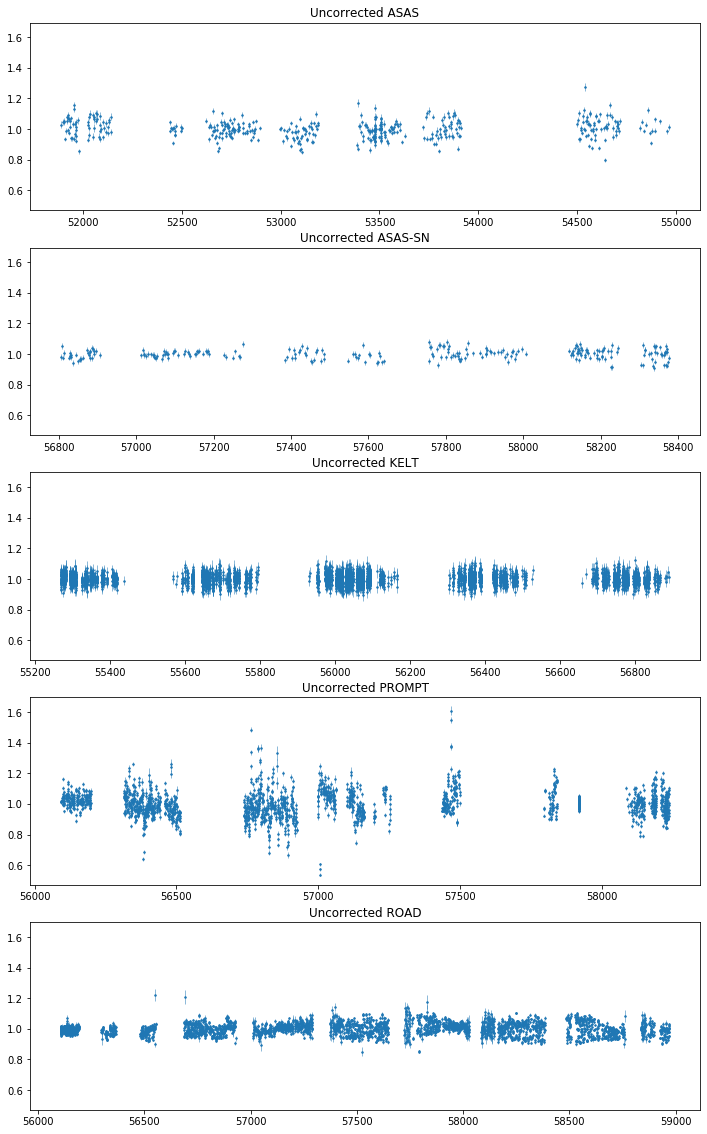

In [7]:
times = [asas_data['MJD'], asassn_data['MJD'], kelt_data['HJD'], prompt_data['HJD'], road_data['HJD']]
fluxes = [asas_flux, asassn_flux, kelt_flux, prompt_flux, road_flux]
uncertainties = [asas_eflux, asassn_eflux, kelt_eflux, prompt_eflux, road_eflux]
names = ['ASAS', 'ASAS-SN', 'KELT', 'PROMPT', 'ROAD']

fig, ax = plt.subplots(5, sharey= True)

for i in range(5):
    time, flux, eflux = times[i], fluxes[i], uncertainties[i]
    
    

    ax[i].errorbar(time, flux, eflux, fmt='.', markersize= 3, elinewidth=0.5)
    figure = plt.gcf()
    figure.set_size_inches(12, 20)
    ax[i].set_title("Uncorrected " +str(names[i]))
    #ax[i].set_ylim(0.86, 1.08)
    print("Scatter is", np.std(flux))


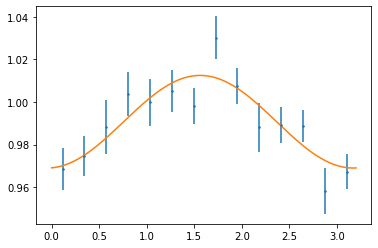

The max is at:  1.013
The min is at:  0.969
The amp is at:  0.044
[0.00256642 0.00370037 0.00353364]


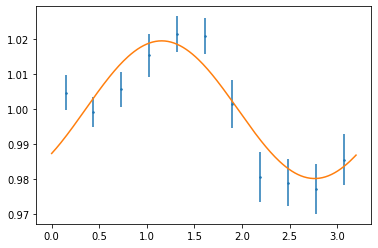

The max is at:  1.020
The min is at:  0.980
The amp is at:  0.039
[0.00178613 0.00258246 0.00240026]


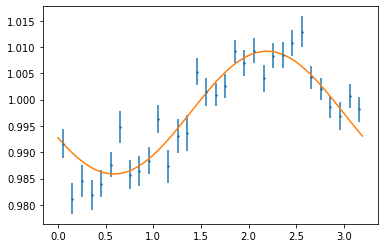

The max is at:  1.009
The min is at:  0.986
The amp is at:  0.023
[0.00045571 0.00064975 0.00063309]


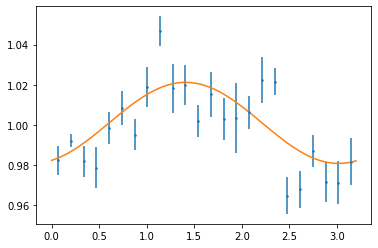

The max is at:  1.021
The min is at:  0.981
The amp is at:  0.040
[0.00174213 0.00246858 0.00235492]


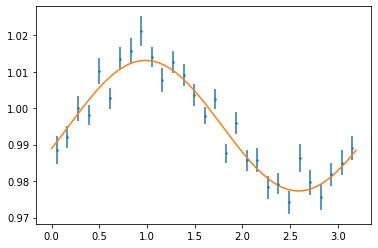

The max is at:  1.013
The min is at:  0.977
The amp is at:  0.036
[0.00057935 0.00083588 0.00079941]


In [8]:
for i in range(5):
    time, flux, eflux = times[i], fluxes[i], uncertainties[i]
    
    frequencies = 1/np.linspace(2, 10, 3000)
    power = LombScargle(time, flux-np.mean(flux), dy = eflux).power(frequencies)
    max_period = 1/frequencies[list(power).index(np.max(power))]
    
    means, errors, midpoints = binner(np.linspace(0, max_period, int(2*len(time)**(1/3.))), time%max_period, flux, eflux)
    
    popt, pcov = curve_fit(ringaling, np.array(midpoints)*2*np.pi/(max_period), means, sigma = errors, absolute_sigma = True, p0 = [1,0,0], maxfev = 5000)
    phi = np.arange(200)*2*np.pi / 200
    
    plt.errorbar(midpoints, means, errors, ms = 3, fmt = '.')
    plt.plot(phi*max_period/(2*np.pi), ringaling(phi, *popt))
    plt.show()
    
    print("The max is at: ", '{0:.3f}'.format(np.max(ringaling(phi, *popt))))
    print("The min is at: ", '{0:.3f}'.format(np.min(ringaling(phi, *popt))))
    print("The amp is at: ", '{0:.3f}'.format(np.max(ringaling(phi, *popt))-np.min(ringaling(phi, *popt))))
    print(np.sqrt(np.diag(pcov)))

## Periodic correction

In [9]:
#Full periodogram
names = ['ASAS', 'ASASSN', 'KELT', 'PROMPT', 'ROAD']
corr_fluxes_1, corr_fluxes_2 = [], []

org_powers, powers2 = [], []
for j in range(5):
    time, flux, eflux = times[j], fluxes[j], uncertainties[j]

    road_corrflux, periods, road_freq1, road_power1 = bro.short_correct(time, flux, eflux, min_chunk_size = 10)

    #Get the uncorrected lombscargle
    frequencies = 1/np.linspace(2, 10, 3000)
    org_power = LombScargle(time, flux-np.mean(flux), dy = eflux).power(frequencies)
    org_max_period = 1/frequencies[list(org_power).index(np.max(org_power))]
    #print("The highest power period is ", '{0:.3f}'.format(org_max_period), ' days.')

    #Get the butcher corrected lombscargle
    butcher_flux, butcher_periods = butcher.short_correct(time, flux, eflux)
    frequencies = 1/np.linspace(2, 10, 3000)
    butcher_power = LombScargle(time, butcher_flux-np.mean(butcher_flux), dy = eflux).power(frequencies)
    butcher_max_period = 1/frequencies[list(butcher_power).index(np.max(butcher_power))]
    #print("The highest power period is ", '{0:.3f}'.format(butcher_max_period), ' days.')
    
    #Get the bro corrected lombscargle
    frequencies = 1/np.linspace(2, 10, 3000)
    power = LombScargle(time, road_corrflux-np.mean(road_corrflux), dy = eflux).power(frequencies)
    max_period = 1/frequencies[list(power).index(np.max(power))]
    #print("The highest power period is ", '{0:.3f}'.format(max_period), ' days.')
    
    road_corrflux2, periods2, road_freq1, road_power1 = bro.short_correct(time, road_corrflux, eflux, min_chunk_size = 10)
    frequencies = 1/np.linspace(2, 10, 3000)
    power2 = LombScargle(time, road_corrflux2-np.mean(road_corrflux2), dy = eflux).power(frequencies)
    max_period = 1/frequencies[list(power2).index(np.max(power2))]
    
    org_powers.append(org_power)
    powers2.append(power2)
    
    
    #plt.plot(1/frequencies, power2-power)
    #fig = plt.gcf()
    #fig.set_size_inches(12,9)
    #plt.show()
    
    corr_fluxes_1.append(road_corrflux)
    corr_fluxes_2.append(road_corrflux2)
    
    print(periods)
    print(periods2)
    print("The scatter is now: ", np.std(road_corrflux))
    print("The scatter is now: ", np.std(road_corrflux2))
#0.04687787284474136
#0.021
#0.028
#0.069
#0.023

[3.18972991 3.2084028  3.21907302 2.2294098  2.51217072 3.20573525
 3.19773258]
[2.97365789 7.54318106 3.48316105 2.12004001 2.         2.37612538
 2.31743915]
The scatter is now:  0.0477051479846159
The scatter is now:  0.04409085364625319


C:\Users\MasterofAlorgia\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:729: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


[2.65355118 3.17372457 3.22440814 3.22174058 3.21107036 3.19506502
 3.21373791]
[3.20040013 7.1297099  2.09336445 2.35478493 3.17639213 3.5711904
 2.68556185]
The scatter is now:  0.016815254531105776
The scatter is now:  0.014168425631592268
[3.16572191 3.15771924 3.2084028  2.6588863  3.21107036 3.17905969
 3.2084028 ]
[3.21907302 2.29343114 2.10136712 3.1843948  2.04001334 2.61087029
 6.16672224]
The scatter is now:  0.029325350270105695
The scatter is now:  0.02873385658705304
[5.75591864 5.00100033 3.38712904 3.22974325 3.20040013 3.17639213
 3.2750917  3.20040013 3.19506502]
[4.33677893 2.48816272 5.15305102 4.92364121 4.93164388 9.33577859
 2.04534845 8.22874291 5.58519507]
The scatter is now:  0.07896614741130174
The scatter is now:  0.07665536307497574
[7.64454818 2.67755919 3.1843948  3.20306769 3.19506502 3.21907302
 3.20040013 3.21640547 3.19506502 3.20573525 3.20573525 3.21640547
 3.22974325]
[2.48816272 3.20573525 2.6402134  3.17639213 3.24574858 2.67755919
 2.39213071 3.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


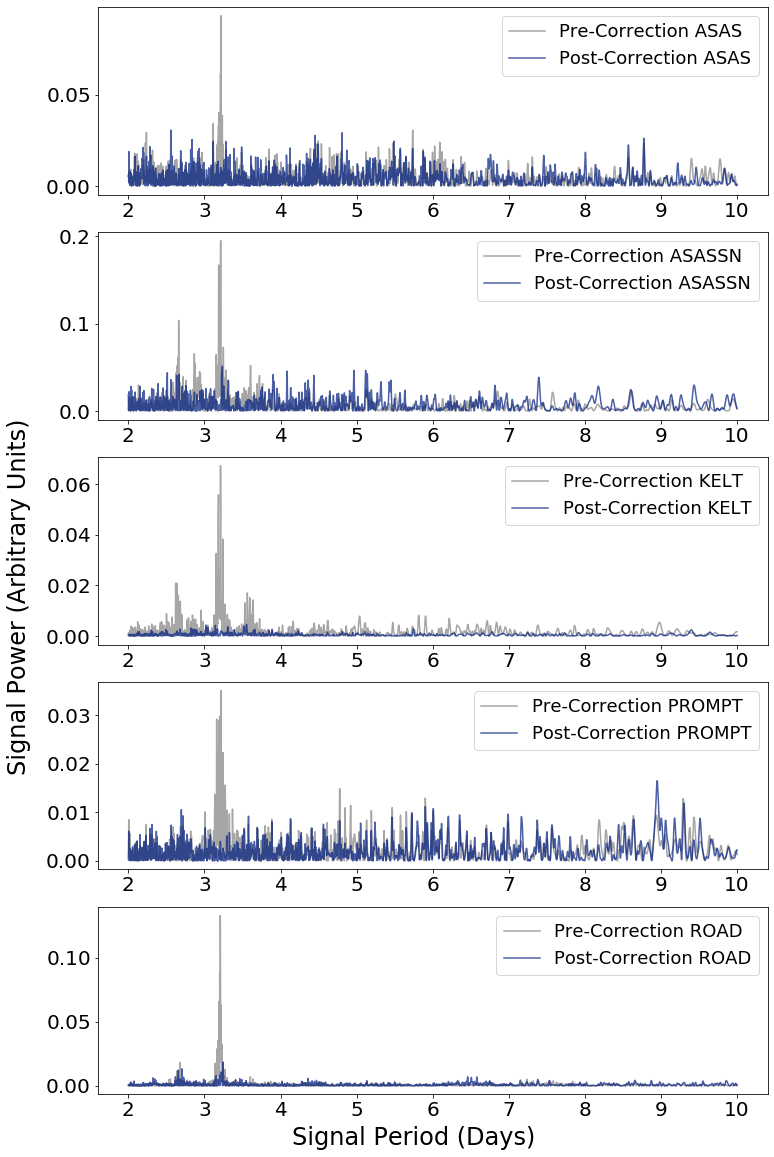

In [10]:
import matplotlib
plt.style.use('seaborn-dark-palette')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(5)
for i in range(5):
    ax[i].plot(1/frequencies, org_powers[i], alpha = 0.7, c='grey', label = 'Pre-Correction ' + names[i])
    #ax.plot(1/frequencies, butcher_power, alpha = 0.7, c = 'orange', label = 'Butcher-Correction')
    ax[i].plot(1/frequencies, powers2[i], alpha = 0.7,label = 'Post-Correction ' + names[i])
    ax[i].legend(fontsize = 18)

fig.text(0.35, 0.09, 'Signal Period (Days)', fontsize = 24)
fig.text(0.02, 0.35, 'Signal Power (Arbitrary Units)', rotation = 90, fontsize = 24)
fig = plt.gcf()
fig.set_size_inches(12,20)
#plt.savefig('Removing_Dominant_Cycle.pdf')
plt.show()

## Removing 2+ sigma outliers



In [11]:
len_before = 0
for i in range(5):
    len_before += len(times[i])


for i in range(5):
    #print(len(corr_fluxes_2[i]))
    #print(np.min(times[i]), np.max(times[i]))
    flux_1, flux_2 = corr_fluxes_1[i], corr_fluxes_2[i]
    low_1, high_1 = np.percentile(flux_1,[5, 95]) 
    low_2, high_2 = np.percentile(flux_2,[5, 95])
    print(low_1, high_1)
    print(low_2, high_2)
    mask1 = (flux_1 < high_1)*(flux_1 > low_1)
    mask2 = (flux_2 < high_2)*(flux_2 > low_2)
    
    corr_fluxes_1[i], corr_fluxes_2[i] = flux_1[mask1], flux_2[mask2]
    times[i], uncertainties[i] = times[i][mask2], uncertainties[i][mask2]
    
len_after = 0
for i in range(5):
    len_after += len(times[i])
print("We removed: ", '{0:.2f}'.format((len_before-len_after)*100/len_before), ' % of the data')

all_corflux = np.concatenate( (np.array(corr_fluxes_2[0]+1), np.array(corr_fluxes_2[1]+1), np.array(corr_fluxes_2[2]+1), np.array(corr_fluxes_2[3]+1),  np.array(corr_fluxes_2[4]+1)))
print(np.std(all_corflux))


-0.08052741736010507 0.08176510698079671
-0.06854258037867482 0.07466694152828657
-0.02563720873556681 0.024568831592480835
-0.022902822793732413 0.021464013339299134
-0.047059265214328246 0.04980359401120504
-0.04630380163034945 0.04891749403826091
-0.10573124112581261 0.1349850291562583
-0.09845509929443934 0.12746511198485874
-0.035199266495255704 0.04026230602331946
-0.031691530196997914 0.03672015496982485
We removed:  10.04  % of the data
0.027953210799522205


In [13]:
#Sticking the different sets together
all_times =  np.concatenate((np.array(times[0]), np.array(times[1]), np.array(times[2]), np.array(times[3]), np.array(times[4])))
all_corflux = np.concatenate( (np.array(corr_fluxes_2[0]+1), np.array(corr_fluxes_2[1]+1), np.array(corr_fluxes_2[2]+1), np.array(corr_fluxes_2[3]+1),  np.array(corr_fluxes_2[4]+1)))
all_eflux =  np.concatenate((np.array(uncertainties[0]), np.array(uncertainties[1]), np.array(uncertainties[2]), np.array(uncertainties[3]), np.array(uncertainties[4])))

#np.concatenate((np.array(times[2]), np.array(times[4])))
#np.concatenate((np.array(corr_fluxes_2[2]), np.array(corr_fluxes_2[4])))
#np.concatenate((np.array(uncertainties[2]), np.array(uncertainties[4])))



print(len(all_times), len(all_corflux), len(all_eflux))

all_times_final, all_corflux_final, all_eflux_final = zip(*sorted(zip(all_times, all_corflux, all_eflux))) #Sorting the data timewise

print(len(all_times_final), len(all_corflux_final))

print(np.std(all_corflux))

karpa = np.zeros((len(all_times_final), 3))
karpa[:, 0] = all_times_final
karpa[:, 1] = all_corflux_final
karpa[:, 2] = all_eflux_final

9843 9843 9843
9843 9843
0.027953210799522205


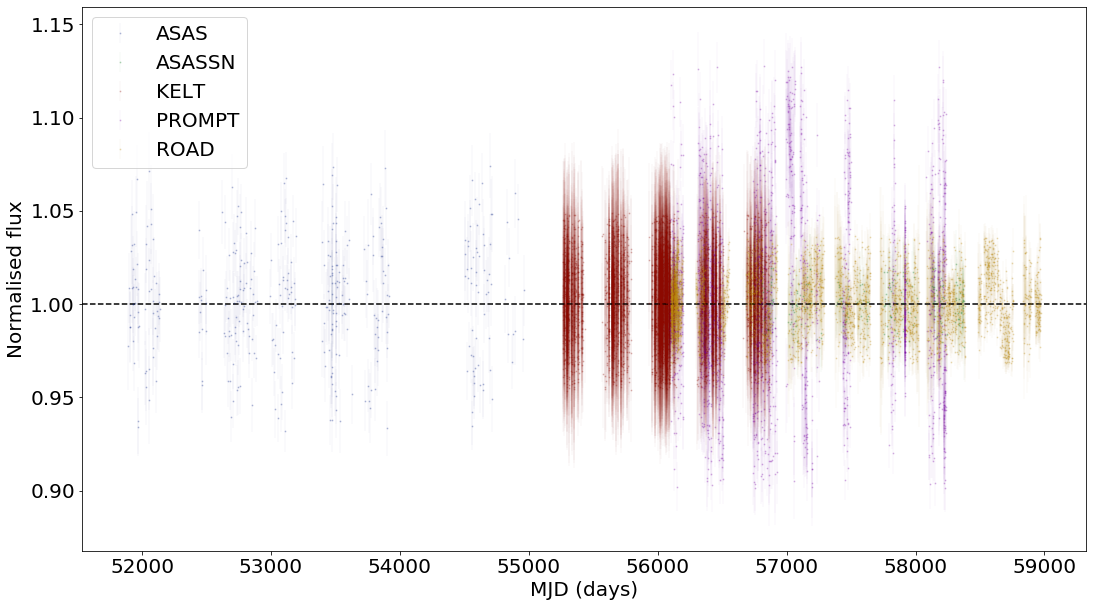

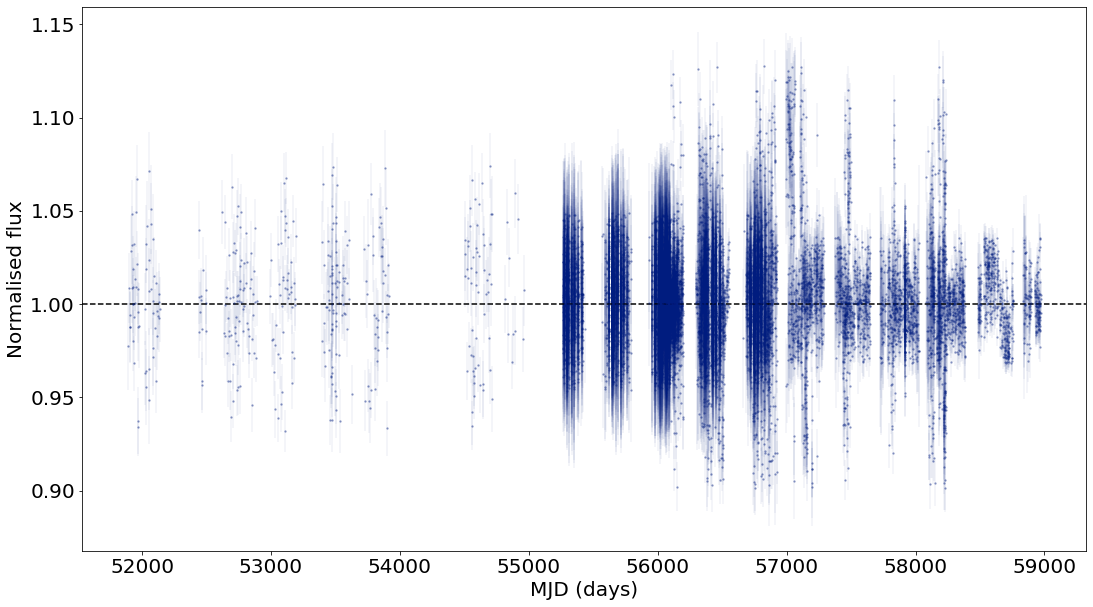

In [31]:
plt.style.use('seaborn-dark-palette')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

for i in range(5):
    plt.errorbar(times[i], corr_fluxes_2[i]+1, uncertainties[i], fmt='.', ms=2, elinewidth = 0.2, alpha = 0.2, label = names[i])
    
plt.xlabel('MJD (days)')
plt.ylabel('Normalised flux')
figure = plt.gcf()
figure.set_size_inches(18, 10)
plt.axhline(y = 1.0, linestyle = '--', c='black')
plt.legend()
#plt.savefig("KARPA_Lightcurve.pdf")
plt.show()    
    
plt.errorbar(karpa[:, 0], karpa[:, 1], yerr=karpa[:, 2], fmt='.', ms=3, elinewidth = 0.3, alpha = 0.3)
plt.xlabel('MJD (days)')
plt.ylabel('Normalised flux')
figure = plt.gcf()
figure.set_size_inches(18, 10)
plt.axhline(y = 1.0, linestyle = '--', c='black')
plt.show()

0.9999999999999998
0.9990556784861513


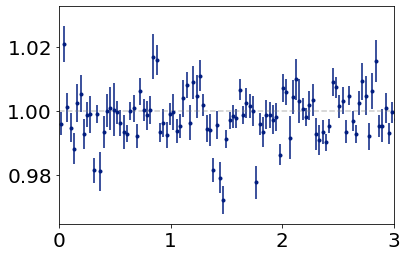

In [21]:
print(np.mean(karpa[:, 1]))
per = 8.025650930249851

means, errors, midpoints = binner(np.linspace(0, per, 271), karpa[:, 0]%per, karpa[:, 1], karpa[:, 2])
print(np.mean(means))
plt.errorbar(midpoints, means, errors, fmt = '.')
plt.axhline(y = 1, linestyle = '--', c='grey', alpha = 0.4)
plt.xlim(0, 3)
plt.show()

#plt.errorbar(karpa[:, 0]%per, karpa[:, 1], karpa[:, 2], fmt = '.', ms= 0.5, elinewidth = 0.1)
#plt.axhline(y = 1, linestyle = '--', c='grey', alpha = 0.4)
#fig = plt.gcf()
#fig.set_size_inches(12, 9)
#plt.show()


In [13]:
karpa[: , 1] /= np.mean(karpa[:, 1])
print(np.mean(karpa[:, 1]))
#np.savetxt("Final_KARPA_Data_BRO2.csv", karpa, header = 'Time,Flux,Eflux') 

0.9999999999999998
